In [ ]:
from time import time
def time_it(f, *args, n=100):
    s = time()
    for _ in range(n):
        f(*args)
    f = time()
    return (f-s)/n

def avg_time(f, *args, n=10, m=100):
    hold = np.zeros(n)
    for _ in range(n):
        hold[_] = time_it(f, *args, n=m)
    return f"{np.mean(hold)*1000:.2f} ± {np.std(hold)*1000:.0f} ms per loop (mean ± std. dev. of {n} runs, {m} loops each)"

In [1]:
import pandas as pd
import numpy as np
from events import load_event_DataFrames, add_complex_observables, df_observables
from nptreeclassifiers import df_to_ML_input, BinaryTreeClassifier
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from analysis import find_p_cut, S_B_ratio

In [78]:
sgn_df, bkg_df = load_event_DataFrames('pp_h_2mu2e')

In [79]:
sgn_df = add_complex_observables(sgn_df)
bkg_df = add_complex_observables(bkg_df)

In [80]:
input_observables = ['m_H', 'Z_mu_rap', 'Z_e_rap', 'mu-_px', 'e-_py','signal']

sgn_data = sgn_df[input_observables]
bkg_data = bkg_df[input_observables]

data = pd.concat([sgn_data,bkg_data], ignore_index=True)

In [81]:
obs, labs = df_to_ML_input(data)

In [82]:
def score(Y, Y_pred):
    try:
        obsv = ['observables' for _ in Y]
        results = list(zip(obsv, Y, Y_pred))

        p_cut = find_p_cut(results)

        return S_B_ratio(p_cut, results)
    
    except ZeroDivisionError:
        return 0.0

scorer = make_scorer(score, greater_is_better=True)

In [8]:
parameters = {'max_depth':         [1, 10, 100, 1000],   #list(np.linspace(1, 20, 20)),
              'min_samples_split': [1, 10, 100, 1000],   #list(np.linspace(0, 8000, 21)),
              'min_samples_leaf':  [1, 10, 100, 1000]}   #list(np.linspace(0, 6000, 21))}

grid = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [9]:
grid.fit(obs, labs)

C:\Users\Student\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<nptreeclassifiers.BinaryTreeClassifier object at 0x0000023E56232A20>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 10, 100, 1000], 'min_samples_split': [1, 10, 100, 1000], 'min_samples_leaf': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=make_scorer(score), verbose=0)

In [35]:
res = pd.DataFrame(grid.cv_results_)
params = res.loc[res.mean_test_score == res.mean_test_score.max()].params.values
params, res.mean_test_score.max()

(array([{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 1},
        {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 10},
        {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100},
        {'max_depth': 100, 'min_samples_leaf': 100, 'min_samples_split': 1},
        {'max_depth': 100, 'min_samples_leaf': 100, 'min_samples_split': 10},
        {'max_depth': 100, 'min_samples_leaf': 100, 'min_samples_split': 100},
        {'max_depth': 1000, 'min_samples_leaf': 100, 'min_samples_split': 1},
        {'max_depth': 1000, 'min_samples_leaf': 100, 'min_samples_split': 10},
        {'max_depth': 1000, 'min_samples_leaf': 100, 'min_samples_split': 100}],
       dtype=object), 2.7557514775162844)

In [25]:
parameters = {'max_depth':         [10, 100, 500, 1000],   #[1, 10, 100, 1000],
              'min_samples_split': [50, 100, 200, 300],    #[1, 10, 100, 1000],
              'min_samples_leaf':  [1, 10, 100, 1000]}     #[1, 10, 100, 1000]

grid1 = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [26]:
grid1.fit(obs, labs)

C:\Users\Student\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<nptreeclassifiers.BinaryTreeClassifier object at 0x0000023E57F4E0F0>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 100, 500, 1000], 'min_samples_split': [50, 100, 200, 300], 'min_samples_leaf': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=make_scorer(score), verbose=0)

In [34]:
res = pd.DataFrame(grid1.cv_results_)
params = res.loc[res.mean_test_score == res.mean_test_score.max()].params.values
params, res.mean_test_score.max()

(array([{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 300},
        {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 300},
        {'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 300},
        {'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 300}],
       dtype=object), 2.7816097353482068)

In [30]:
parameters = {'max_depth':         [5, 8, 10, 15, 20],         # [10, 100, 500, 1000],
              'min_samples_split': [250, 275, 300, 325, 350],  # [50, 100, 200, 300],
              'min_samples_leaf':  [10, 50, 100, 150, 200]}    # [1, 10, 100, 1000]

grid2 = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [31]:
grid2.fit(obs, labs)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<nptreeclassifiers.BinaryTreeClassifier object at 0x0000023E57F65630>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 8, 10, 15, 20], 'min_samples_split': [250, 275, 300, 325, 350], 'min_samples_leaf': [10, 50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=make_scorer(score), verbose=0)

In [68]:
res = pd.DataFrame(grid2.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 250},
        {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 275},
        {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 300},
        {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 325},
        {'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 250},
        {'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 275},
        {'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 300},
        {'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 325},
        {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 250},
        {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 275},
        {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 300},
        {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 325},
        {'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 

In [70]:
parameters = {'max_depth':         [3, 5, 10, 15],             # [5, 8, 10, 15, 20],  
              'min_samples_split': [200, 250, 275, 300, 325],  # [250, 275, 300, 325, 350],
              'min_samples_leaf':  [5, 50, 75, 100, 125, 150]}    # [10, 50, 100, 150, 200]

grid3 = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [71]:
grid3.fit(obs, labs)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<nptreeclassifiers.BinaryTreeClassifier object at 0x0000023E580497F0>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 10, 15], 'min_samples_split': [200, 250, 275, 300, 325], 'min_samples_leaf': [5, 50, 75, 100, 125, 150]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=make_scorer(score), verbose=0)

In [72]:
res = pd.DataFrame(grid3.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 275},
        {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 300},
        {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 325},
        {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 275},
        {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 300},
        {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 325}],
       dtype=object), 2.7816097353482068)

In [101]:
parameters = {'max_depth':         [8, 9, 10, 11, 12],         # [3, 5, 10, 15],  
              'min_samples_split': [275, 290, 300, 310, 325],  # [200, 250, 275, 300, 325],
              'min_samples_leaf':  [3, 5, 25, 50, 100]}        # [5, 50, 75, 100, 125, 150]

grid4 = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [102]:
s = time()
grid4.fit(obs, labs)
f = time()

h  = (f-s) // 3600
m  = ((f-s) - h*3600) // 60
s  = ((f-s) - h*3600 - m*60) // 1
ms = ((f-s) - h*3600 - m*60 - s) * 1000
print(f"{h} hr, {m} min, {s} sec, {ms:.2f} ms")

0.0 hr, 6.0 min, 19.0 sec, 1549994641018.45 ms


In [103]:
res = pd.DataFrame(grid4.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 275},
        {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 290},
        {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 300},
        {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 310},
        {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 325},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 275},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 290},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 300},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 310},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 325},
        {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 275},
        {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 290},
        {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 300},
        {'max_depth': 9, 

In [104]:
parameters = {'max_depth':         [5, 6, 7, 8, 9, 10],         # [8, 9, 10, 11, 12] 
              'min_samples_split': [250, 275, 300, 325, 350],  # [275, 290, 300, 310, 325]
              'min_samples_leaf':  [1, 5, 10, 50, 100, 150]}        # [3, 5, 25, 50, 100]

grid5 = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [105]:
s = time()
grid5.fit(obs, labs)
f = time()

h  = (f-s) // 3600
m  = ((f-s) - h*3600) // 60
s  = ((f-s) - h*3600 - m*60) // 1
ms = ((f-s) - h*3600 - m*60 - s) * 1000
print(f"{h} hr, {m} min, {s} sec, {ms:.2f} ms")

0.0 hr, 6.0 min, 45.0 sec, 1549999119820.40 ms


In [106]:
res = pd.DataFrame(grid5.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 275},
        {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 300},
        {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 325},
        {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 350},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 275},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 300},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 325},
        {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 350},
        {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 275},
        {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 300},
        {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 325},
        {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 350},
        {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 275},
        {'max_depth': 9, 

In [118]:
parameters = {'max_depth':         [10,],         # [8, 9, 10, 11, 12] 
              'min_samples_split': list(range(200,301)),  # [275, 290, 300, 310, 325]
              'min_samples_leaf':  [50,]}        # [3, 5, 25, 50, 100]

grid6 = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [119]:
s = time()
grid6.fit(obs, labs)
f = time()

h  = (f-s) // 3600
m  = ((f-s) - h*3600) // 60
s  = ((f-s) - h*3600 - m*60) // 1
ms = ((f-s) - h*3600 - m*60 - s) * 1000
print(f"{h} hr, {m} min, {s} sec, {ms:.2f} ms")

0.0 hr, 5.0 min, 31.0 sec, 1550014336167.51 ms


In [120]:
res = pd.DataFrame(grid6.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 238},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 239},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 240},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 241},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 242},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 243},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 244},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 245},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 246},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 247},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 248},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 249},
        {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 250},

In [22]:
from time import time

In [31]:
parameters

{'max_depth': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0],
 'min_samples_split': [100.0,
  112.0,
  124.0,
  136.0,
  148.0,
  160.0,
  172.0,
  184.0,
  196.0,
  208.0,
  220.0,
  232.0,
  244.0,
  256.0,
  268.0,
  280.0,
  292.0,
  304.0,
  316.0,
  328.0,
  340.0,
  352.0,
  364.0,
  376.0,
  388.0,
  400.0],
 'min_samples_leaf': [0.0,
  20.0,
  40.0,
  60.0,
  80.0,
  100.0,
  120.0,
  140.0,
  160.0,
  180.0,
  200.0,
  220.0,
  240.0,
  260.0,
  280.0,
  300.0,
  320.0,
  340.0,
  360.0,
  380.0,
  400.0]}

In [32]:
parameters = {'max_depth':         list(np.linspace(1,20,20)),         # [8, 9, 10, 11, 12] 
              'min_samples_split': list(np.linspace(100,400,26)),  # [275, 290, 300, 310, 325]
              'min_samples_leaf':  list(np.linspace(0,400,21))}        # [3, 5, 25, 50, 100]

grid_plot = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=5, scoring=scorer, refit=False, n_jobs=-1)

In [33]:
s = time()
grid_plot.fit(obs, labs)
f = time()

h  = (f-s) // 3600
m  = ((f-s) - h*3600) // 60
s  = ((f-s) - h*3600 - m*60) // 1
ms = ((f-s) - h*3600 - m*60 - s) * 1000
print(f"{h} hr, {m} min, {s} sec, {ms:.2f} ms")

6.0 hr, 15.0 min, 21.0 sec, 1550097364036.91 ms


C:\Users\Student\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [34]:
with open('Data/BinaryTree_Hyperparameter_Grid.pkl', 'wb') as f:   # Pickle file is newly created where foo1.py is
    pkl.dump(grid_plot, f, -1)          # dump data to f

In [35]:
res = pd.DataFrame(grid_plot.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 6.0, 'min_samples_leaf': 20.0, 'min_samples_split': 100.0}],
       dtype=object), 3.915505663495847)

In [288]:
res = pd.DataFrame(grid_plot.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 200.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 205.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 210.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 215.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 220.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 225.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 230.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 235.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 240.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 245.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 250.0},
        {'max_depth': 5.0, 'min_samples_leaf': 30.0, 'min_samples_split': 255.0},
        {'max_de

### FIGURES BELOW

In [3]:
import pickle as pkl

In [4]:
import seaborn as sns

In [5]:
with open('Data/BinaryTree_Hyperparameter_Grid.pkl', 'rb') as f:   # Pickle file is newly created where foo1.py is
    my_grid = pkl.load(f)

In [6]:
my_grid

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<nptreeclassifiers.BinaryTreeClassifier object at 0x0000021610C210B8>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0], 'min_samples_split': [100.0, 112.0, 124.0, 136.0, 148.0, 160.0, 172.0, 184.0, 196.0, 208.0, 220.0, 232.0, 244.0, 256.0, 268.0, 280.0, 292.0, 304.0, 316.0, 328.0, ..., 140.0, 160.0, 180.0, 200.0, 220.0, 240.0, 260.0, 280.0, 300.0, 320.0, 340.0, 360.0, 380.0, 400.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=make_scorer(score), verbose=0)

In [7]:
res = pd.DataFrame(my_grid.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()
res

C:\Users\Student\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Student\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Student\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwa

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.156216,0.009879,0.068730,7.653917e-03,1,0,100,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
1,0.140589,0.009880,0.065608,6.249285e-03,1,0,112,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
2,0.143713,0.006251,0.068733,7.653273e-03,1,0,124,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
3,0.137466,0.011690,0.068734,7.654052e-03,1,0,136,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
4,0.143716,0.006249,0.065610,6.248808e-03,1,0,148,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
5,0.137468,0.006248,0.065613,6.254077e-03,1,0,160,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
6,0.143717,0.011691,0.065608,6.249976e-03,1,0,172,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
7,0.137468,0.011692,0.065610,6.248617e-03,1,0,184,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
8,0.137467,0.006249,0.068734,7.652028e-03,1,0,196,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046
9,0.137469,0.006248,0.065609,6.248856e-03,1,0,208,"{'max_depth': 1.0, 'min_samples_leaf': 0.0, 'm...",0.0,0.0,...,0.116816,0.233631,10401,0.263837,0.263181,0.584079,0.584079,0.584079,0.455851,0.157046


In [8]:
param_grid = pd.DataFrame([{**params, 'Signal_to_Noise_ratio': SN}
                          for params, SN in res[['params', 'mean_test_score']].values])
param_grid

,Signal_to_Noise_ratio,max_depth,min_samples_leaf,min_samples_split
0,0.116816,1.0,0.0,100.0
1,0.116816,1.0,0.0,112.0
2,0.116816,1.0,0.0,124.0
3,0.116816,1.0,0.0,136.0
4,0.116816,1.0,0.0,148.0
5,0.116816,1.0,0.0,160.0
6,0.116816,1.0,0.0,172.0
7,0.116816,1.0,0.0,184.0
8,0.116816,1.0,0.0,196.0
9,0.116816,1.0,0.0,208.0


In [9]:
n_params = (param_grid.shape[1] - 1)

In [10]:
import matplotlib.pyplot as plt

ADD
0 0 min_samples_split -> max_depth AxesSubplot(0.125,0.536818;0.352273x0.343182)
[[2.00000000e+02 1.00000000e+00 1.16815702e-01]
 [2.05000000e+02 1.00000000e+00 1.16815702e-01]
 [2.10000000e+02 1.00000000e+00 1.16815702e-01]
 ...
 [2.90000000e+02 2.00000000e+01 1.76858972e+00]
 [2.95000000e+02 2.00000000e+01 1.76858972e+00]
 [3.00000000e+02 2.00000000e+01 1.76858972e+00]]
ADD
1 0 min_samples_leaf -> max_depth AxesSubplot(0.125,0.125;0.352273x0.343182)
[[0.00000000e+00 1.00000000e+00 1.16815702e-01]
 [0.00000000e+00 1.00000000e+00 1.16815702e-01]
 [0.00000000e+00 1.00000000e+00 1.16815702e-01]
 ...
 [3.00000000e+02 2.00000000e+01 1.76858972e+00]
 [3.00000000e+02 2.00000000e+01 1.76858972e+00]
 [3.00000000e+02 2.00000000e+01 1.76858972e+00]]
ADD
1 1 min_samples_leaf -> min_samples_split AxesSubplot(0.547727,0.125;0.352273x0.343182)
[[0.00000000e+00 2.00000000e+02 1.16815702e-01]
 [0.00000000e+00 2.05000000e+02 1.16815702e-01]
 [0.00000000e+00 2.10000000e+02 1.16815702e-01]
 ...
 [3.0

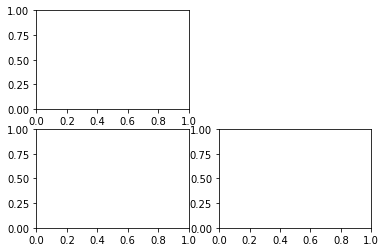

In [357]:
fig, axes = plt.subplots(n_params-1, n_params-1)
params = {'max_depth':7, 'min_samples_split':250, 'min_samples_leaf':30}
cs, xs, ys, zs = param_grid.values.T

for yi, y_param in enumerate(params[1:]):
    for xi, x_param in enumerate(params[:-1]):
        
        if yi < xi:
            axes[yi, xi].remove()
            continue
        
        print('ADD')
        mask = np.all([param_grid['max_depth']==1.0,
               param_grid['min_samples_split']==200.0,
               param_grid['min_samples_leaf']==30.0],
              axis=0)
        param_grid[mask].values

        print(yi, xi, y_param, '->', x_param, axes[yi, xi])

        print(param_grid[[y_param, x_param, 'Signal_to_Noise_ratio']].values)

In [373]:
df = param_grid[['max_depth', 'min_samples_split', 'Signal_to_Noise_ratio']]
x_set, y_set = set(df['max_depth']), set(df['min_samples_split'])
size = (len(x_set), len(y_set))

In [375]:
x_set, y_set, size

({1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0},
 {200.0,
  205.0,
  210.0,
  215.0,
  220.0,
  225.0,
  230.0,
  235.0,
  240.0,
  245.0,
  250.0,
  255.0,
  260.0,
  265.0,
  270.0,
  275.0,
  280.0,
  285.0,
  290.0,
  295.0,
  300.0},
 (20, 21))

In [379]:
df.values[df.values[:,:1] == [1.0, 200.0]]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 3 but corresponding boolean dimension is 2

In [396]:
df[np.all([df.values[:,0] == 1.0, df.values[:,1] == 200.0, df.values[:,2] == ], axis=0)]

,max_depth,min_samples_split,Signal_to_Noise_ratio
0,1.0,200.0,0.116816
21,1.0,200.0,0.116816
42,1.0,200.0,0.116816
63,1.0,200.0,0.116816
84,1.0,200.0,0.116816
105,1.0,200.0,0.116816
126,1.0,200.0,0.116816
147,1.0,200.0,0.116816
168,1.0,200.0,0.116816
189,1.0,200.0,0.116816


In [402]:
param_grid.from_dict({'max_depth':1.0, 'min_samples_split':200.0, 'min_samples_leaf':30.0})

ValueError: If using all scalar values, you must pass an index

In [420]:
mask = np.all([param_grid['max_depth']==1.0,
               param_grid['min_samples_split']==200.0,
               param_grid['min_samples_leaf']==30.0],
              axis=0)
param_grid[mask].values

array([[1.16815702e-01, 1.00000000e+00, 3.00000000e+01, 2.00000000e+02]])

In [11]:
c, x, y, z = param_grid.values.T

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

In [532]:
norm = colors.LogNorm(vmin=c.min(), vmax=c.max())

In [13]:
c_ordered = sorted(list(set(c)))

In [14]:
c_ordered

[0.11681570153251676,
 0.23374615546842734,
 0.23554299752108804,
 0.2374089120702396,
 0.23751268106816623,
 0.23757223862987895,
 0.2376622482476802,
 0.23781481115184303,
 0.23787088380728924,
 0.6585877230551063,
 0.6703085327124622,
 0.7022137686478542,
 0.7809317870516393,
 0.7903119337902708,
 0.8108466167150005,
 0.824243619132015,
 0.8273172435663171,
 0.8472361928119894,
 0.868181690755587,
 0.9286848271835082,
 1.0003313806569796,
 1.0581897188211105,
 1.0588641545883646,
 1.0841607028336369,
 1.2654499964454615,
 1.2671020199395155,
 1.2704060669276238,
 1.3269358752874518,
 1.3339014179398796,
 1.3391255749292001,
 1.358280817223376,
 1.4138925978811765,
 1.4157396162977425,
 1.434209800463401,
 1.4996674921017128,
 1.507565675075257,
 1.5233620410223454,
 1.5302729511241968,
 1.7685897212023036,
 1.7755986632942549,
 1.7826076053862057,
 1.9760373812105456,
 2.2364889012802465,
 2.277207175275233,
 2.27871525949727,
 2.729893219684362,
 2.731740238100928,
 2.7372812933506

In [74]:
%matplotlib qt

# cmap = sns.color_palette("Blues", as_cmap=True)
# cmap = sns.cubehelix_palette(100, light=1.0, dark=0.1, rot=4, as_cmap=True)
# cmap = plt.get_cmap('jet')


    
fig = plt.figure(figsize=(14, 11))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap("jet")
cax = ax.scatter(x, y, z, s=115, c=c, cmap=cmap, marker='s', alpha=0.45)

cbar = plt.colorbar(cax, ax=ax) 
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(elev=10, azim=-30)

labels = {axis:label.replace('_',' ')
          for axis, label in
          zip(['c','x','y','z'], param_grid.columns)}

ax.set_xlabel(labels['x'])
ax.set_ylabel(labels['y'])
ax.set_zlabel(labels['z'])
cbar.set_label(labels['c'], rotation=270)


fig.tight_layout()
plt.show()

In [29]:
{axis:label.replace('_',' ') for axis, label in zip(['c','x','y','z'], param_grid.columns)}

{'c': 'Signal to Noise ratio',
 'x': 'max depth',
 'y': 'min samples leaf',
 'z': 'min samples split'}

In [44]:
fig.show()

In [59]:
srtd_res = pd.DataFrame(sorted(param_grid.loc[param_grid.values[:,0]< np.inf].values, key=lambda row: row[0]), columns=param_grid.columns)

In [64]:
maxes = sorted(list(set(srtd_res.values[:, 0])))[::-1]

In [100]:
srtd_res.loc[srtd_res.values[:,0] == maxes[1]].describe()

,Signal_to_Noise_ratio,max_depth,min_samples_leaf,min_samples_split
count,1.830000e+02,183.000000,183.0,183.000000
mean,2.788998e+00,12.174863,20.0,268.918033
std,8.906151e-16,4.818921,0.0,37.894429
min,2.788998e+00,4.000000,20.0,208.000000
25%,2.788998e+00,8.000000,20.0,232.000000
50%,2.788998e+00,12.000000,20.0,268.000000
75%,2.788998e+00,16.000000,20.0,304.000000
max,2.788998e+00,20.000000,20.0,328.000000


In [71]:
pd.set_option('display.max_rows', 183)

In [86]:
from time import time

In [92]:
parameters = {'max_depth':         [6.0,],
              'min_samples_split': [100.0,],
              'min_samples_leaf':  [20.0,]}

best_search = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=10, scoring=scorer, refit=False, n_jobs=-1)

In [93]:
s = time()
best_search.fit(obs, labs)
f = time()

h  = (f-s) // 3600
m  = ((f-s) - h*3600) // 60
s  = ((f-s) - h*3600 - m*60) // 1
ms = ((f-s) - h*3600 - m*60 - s) * 1000
print(f"{h} hr, {m} min, {s} sec, {ms:.2f} ms")

0.0 hr, 0.0 min, 9.0 sec, 1550165652471.16 ms


In [101]:
res = pd.DataFrame(best_search.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 6.0, 'min_samples_leaf': 20.0, 'min_samples_split': 100.0}],
       dtype=object), 0.0)

In [104]:
parameters = {'max_depth':         [12.0,],
              'min_samples_split': [269.0,],
              'min_samples_leaf':  [20.0,]}
guess_search = GridSearchCV(BinaryTreeClassifier(), param_grid=parameters, cv=10, scoring=scorer, refit=False, n_jobs=-1)

In [105]:
s = time()
guess_search.fit(obs, labs)
f = time()

h  = (f-s) // 3600
m  = ((f-s) - h*3600) // 60
s  = ((f-s) - h*3600 - m*60) // 1
ms = ((f-s) - h*3600 - m*60 - s) * 1000
print(f"{h} hr, {m} min, {s} sec, {ms:.2f} ms")

0.0 hr, 0.0 min, 14.0 sec, 1550165829502.94 ms


In [106]:
res = pd.DataFrame(guess_search.cv_results_)
res_no_inf = res.loc[res.mean_test_score != float('inf')]
params = res_no_inf.loc[res_no_inf.mean_test_score == res_no_inf.mean_test_score.max()].params.values
params, res_no_inf.mean_test_score.max()

(array([{'max_depth': 12, 'min_samples_leaf': 20.0, 'min_samples_split': 269}],
       dtype=object), 0.0)

In [153]:
from analysis import find_p_cut, S_B_ratio, split_data

In [154]:
splt_data = split_data(data)

In [155]:
best_tree = BinaryTreeClassifier(max_depth = 6.0, min_samples_split = 100.0, min_samples_leaf = 20.0)
guess_tree = BinaryTreeClassifier(max_depth = 12.0, min_samples_split = 269.0, min_samples_leaf = 20.0)

In [156]:
best_tree.fit(*df_to_ML_input(splt_data['train']))
guess_tree.fit(*df_to_ML_input(splt_data['train']))

In [157]:
labels = df_to_ML_input(splt_data['test'])[1]

In [158]:
best_res = best_tree.predict(*df_to_ML_input(splt_data['test']))
guess_res = guess_tree.predict(*df_to_ML_input(splt_data['test']))

In [159]:
obs = ['obs' for _ in labels]
best_res = list(zip(obs, labels, best_res))
guess_res = list(zip(obs, labels, guess_res))

In [160]:
best_p = find_p_cut(best_res)
guess_p = find_p_cut(guess_res)

In [161]:
best_SN = S_B_ratio(best_p, best_res)
guess_SN = S_B_ratio(guess_p, guess_res)

In [45]:
best_SN, guess_SN

NameError: name 'best_SN' is not defined